<a href="https://colab.research.google.com/github/maxiuboldi/test_ml/blob/main/test_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Test ML - Clasificador de Noticias**

## Objetivo

Evaluar la posibilidad de entrenar un clasificador que sea capaz de diferenciar las categorías "Política", "Economía" y "Turismo" del diario La Nación.

## Conjunto de datos

El conjunto de datos corresponde a 2.950 documentos de cada categoría ("Política", "Economía" y "Turismo") representados en formato HTML. Los mismos se obtuvieron directamente de la página web del Diario La Nación en el año 2019.

In [ ]:
# Se instalan dependencias adicionales al entorno de ejecución
!pip install newspaper3k yellowbrick scikit-optimize

In [ ]:
from newspaper import Article
import pandas as pd
import numpy as np
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix
import re
from unicodedata import normalize
from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk import download
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
# Descargamos el conjunto de datos desde el Drive público (https://drive.google.com/file/d/18cv5plohpbWMLXIXToX57sqS39vLAxFW/view?usp=sharing) al entorno.
# Ref: https://inside-machinelearning.com/en/quickly-upload-public-google-drive-files-on-notebook-and-colab/
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18cv5plohpbWMLXIXToX57sqS39vLAxFW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18cv5plohpbWMLXIXToX57sqS39vLAxFW" -O la_nacion_dataset.pkl && rm -rf /tmp/cookies.txt

la_nacion_dataset.p 100%[===================>]   1.19G   109MB/s    in 12s     


In [ ]:
# Constantes y configuraciones
SEED = 8888
plt.rcParams['figure.figsize'] = (16, 10)
sns.set()

In [ ]:
# Cargamos el dataset
dataset = pd.read_pickle('la_nacion_dataset.pkl')

In [ ]:
# Inspeccionamos el dataset
dataset.head()

,data,target
0,"<!DOCTYPE html>\r\n<html lang=""es"">\r\n<head>\...",Politica
1,"<!DOCTYPE html>\r\n<html lang=""es"">\r\n<head>\...",Turismo
2,"<!DOCTYPE html>\r\n<html lang=""es"">\r\n<head>\...",Turismo
3,"<!DOCTYPE html>\r\n<html lang=""es"">\r\n<head>\...",Economia
4,"<!DOCTYPE html>\r\n<html lang=""es"">\r\n<head>\...",Turismo


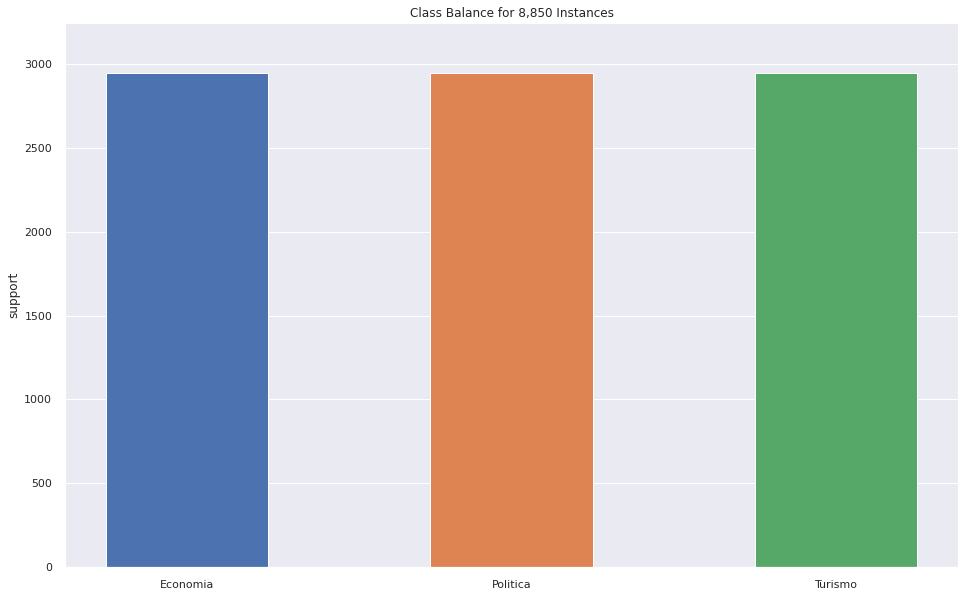

In [ ]:
# Vemos la distribución de clases
ClassBalance().fit(dataset['target']).show()

## Preprocesamiento y generación de matriz TF-IDF

A los fines de generar una estructura adecuada para modelar se opta por la generación de una matriz TF-IDF la cual permite obtener una representación vectorial de cada documento en donde numéricamente se representa la relevancia de cada palabra, o conjunto de palabras, en el documento y la colección de los mismos bajo un esquema de bolsa de palabras (o bag of words) en donde los documentos son representados por la frecuencia de sus palabras, ignorando la posición de las mismas.

A continuación se detallan los pasos del preprocesamiento:

1. Obtención del documento identificando el mismo en el lenguaje español.
2. extracción del HTML de la parte del documento relevante (cuerpo de la noticia) utilizando para ello como inicio el tag asociado al comienzo del párrafo con letra capital (\<p class="capital">) y al fin de la noticia el tag asociado con la opción de indicar si la noticia fue del agrado del lector (\<span class="texto-like">);
3. obtención del texto crudo del cuerpo de la noticia, ignorando etiquetas HTML, funciones JS, etc;
4. se convierten los textos a minúsculas;
5. se remueven corchetes;
6. se remueven paréntesis;
7. se remueven palabras que contienen dígitos;
8. se remueven los saltos de línea;
9. se remueven distintos caracteres no sintácticos como ser símbolos, entrecomillados, numerales, asteriscos, etc.;
10. se sustituyen los múltiples espacios por uno sólo;
11. se excluyen las palabras vacías comunes del lenguaje español (stop words);
12. se aplica la técnica de stemming utilizando para ello el algoritmo Snowball;
13. sin acentos y normalización [NFKD](https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize);
14. se generan unigramas y bigramas;
15. se configura el ignorar los términos con una frecuencia absoluta en los documentos menor a 20 y una máxima del 80%.



In [ ]:
def clean_text(text, lower=False, normal=False):
    """Limpia el texto de cada documento"""
    article = Article('', language='es')  # Extrae el texto del HTML
    # Obtiene el cuerpo de la noticia, luego de la capitalización inicial y hasta el ¿Te gustó esta nota?
    article.set_html(text.split('<p class="capital">', 1)[-1].split('<span class="texto-like">', 1)[0])
    article.parse()
    text = article.text
    if lower:
        text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'[‘’“”\'…«»°*_/¿¡!?;,.\-:"~<>()|·•$#%]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    if normal:
        text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                      normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos
        text = normalize('NFC', text)  # NFC
    return text


def stem_tokens(tokens, stemmer=None):
    """Aplica el stem al token"""
    if stemmer is None:
        stemmer = SnowballStemmer('spanish')
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    """Tokeniza el texto según definición"""
    # 2 o más caracteres alfanuméricos, ignorando la puntuación y tratando los mismos como separadores.
    tokenizer = RegexpTokenizer(r'[a-zA-ZâáàãõáêéíóôõúüÁÉÍÓÚñÑçÇ][0-9a-zA-ZâáàãõáêéíóôõúüÁÉÍÓÚñÑçÇ]+')
    tokens = tokenizer.tokenize(text)
    stems = stem_tokens(tokens)
    return stems

In [ ]:
tqdm.pandas(desc='Preprocesando textos')
dataset['data'] = dataset['data'].progress_apply(clean_text, args=(True, False))
# Existen artículos que no cumplen con las reglas definidas, por ejemplo, que no comienzan con la letra capital, esos casos se eliminan porque quedan en blanco
dataset['data'].replace(' ', np.nan, inplace=True)  # reemplazamos espacios por nulos
dataset['data'].replace('', np.nan, inplace=True)  # reemplazamos vacíos por nulos
dataset.dropna(subset=['data'], inplace=True)  # dropeamos todos los nulos

Preprocesando textos:   0%|          | 0/8850 [00:00<?, ?it/s]

In [ ]:
# Vemos como queda
dataset.head()

,data,target
0,la jueza federal maría servini pidió a interpo...,Politica
1,los colores blanco y azul de mar evocan al med...,Turismo
2,hornaditas la argentina es un país algo perifé...,Turismo
3,las estrategias de mitigación y adaptación ant...,Economia
4,no la estaba pasando bien nueva zelanda en mat...,Turismo


In [ ]:
# Codificamos las clases
le = LabelEncoder()
dataset['target'] = le.fit_transform(dataset['target'])
classes = le.classes_

# Separamos el conjunto en entrenamiento y test
train_data, test_data, train_target, test_target = train_test_split(
    dataset.loc[:, dataset.columns != 'target'],
    dataset['target'],
    test_size=0.2,
    random_state=SEED,
    stratify=dataset['target'])

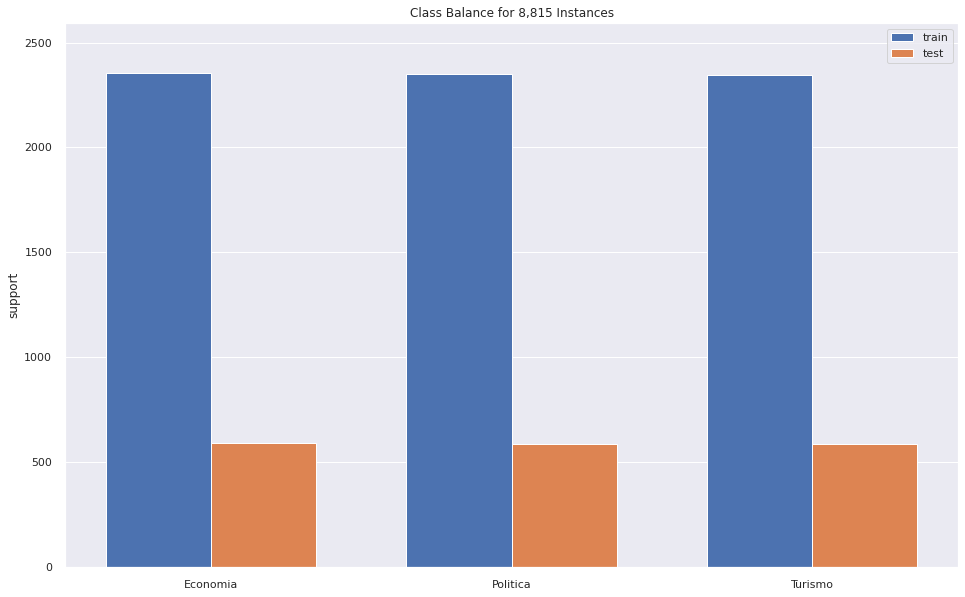

In [ ]:
# Revisamos como queda la distribución de clases
ClassBalance(labels=classes).fit(train_target, test_target).show()

In [ ]:
download('stopwords')
spanish_stops = set(stopwords.words('spanish'))
spanish_stops.update(['tambi'])  # Actualizamos para evitar la inconsistencia

# Se tokenizan las stop words
spanish_stops_stem = stem_tokens(spanish_stops)

# Generamos la matriz
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    ngram_range=(1, 2),
    min_df=20,
    max_df=0.8,
    stop_words=spanish_stops_stem,
    strip_accents='unicode',
    dtype=np.float32
    )
train_data_vec = pd.DataFrame(
    vectorizer.fit_transform(train_data['data']).toarray(),
    columns=vectorizer.get_feature_names_out()
    )
test_data_vec = pd.DataFrame(
    vectorizer.transform(test_data['data']).toarray(),
    columns=vectorizer.get_feature_names_out()
    )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Selección de modelos

La selección del modelo se realiza sobre tres algoritmos, Regresión Logística, LightGBM (*boosting*) y ExtraTrees (*bagging*). Adicionalmente, debido a que la matriz TF-IDF genera una dimensionalidad demasiado elevada, se realiza una selección de features por medio de la métrica **chi2**. La cantidad de features y los hiperprámetros de los algoritmos son optimizados utilizando la técnica bayesiana con 5 folds de cross validation. Es importante mencionar que se optimiza por medio de la métrica **accuracy** teniendo en consideración que el target es balanceado, por lo que es una métrica aceptable.

In [ ]:
# El pipeline se utiliza como un estimador para habilitar la búsqueda sobre diferentes tipos de modelos
pipe = Pipeline([('scl', SelectKBest(score_func=chi2)),
                 ('clf', LGBMClassifier(random_state=SEED))])

# Definimos el espacio de búsqueda
search_space = [
    {
        'clf': [LogisticRegression(random_state=SEED)],
        'scl__k': Integer(50, 300),
        'clf__penalty': Categorical(['l1', 'l2']),
        'clf__C': Real(0.0001, 512., prior='log-uniform'),
        'clf__solver': Categorical(['liblinear', 'saga']),
        'clf__max_iter': Integer(50, 5000)
        },
    {
        'clf': [LGBMClassifier(random_state=SEED)],
        'scl__k': Integer(50, 300),
        'clf__n_estimators': Integer(50, 1000),
        'clf__learning_rate': Real(0.005, 0.1, prior='log-uniform'),
        'clf__subsample': Real(0.0001, 1.0, prior='uniform'),
        'clf__min_child_samples': Integer(1, 500),
        'clf__num_leaves': Integer(10, 512),
        'clf__min_split_gain': Real(0.0, 1.0, prior='uniform'),
        'clf__colsample_bytree': Real(0.05, 1.0, prior='uniform'),
        'clf__max_depth': Integer(0, 100)
        },
    {
        'clf': [ExtraTreesClassifier(random_state=SEED)],
        'scl__k': Integer(50, 300),
        'clf__n_estimators': Integer(50, 1000),
        'clf__criterion': Categorical(['gini', 'entropy']),
        'clf__max_features': Real(0.05, 1.0, prior='uniform'),
        'clf__min_samples_split': Integer(2, 50),
        'clf__min_samples_leaf': Integer(1, 50),
        'clf__bootstrap': Categorical([True, False])
        }
]

# Lanzamos la búsqueda
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_space,
    n_iter=10,  # Lo mantenemos bajo para reducir el tiempo
    scoring='accuracy',
    cv=5,
    random_state=SEED,
    verbose=2,
    refit=True,
    return_train_score=True
    )
opt.fit(train_data_vec, train_target)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf=LogisticRegression(random_state=8888), clf__C=4.7817401307072585, clf__max_iter=644, clf__penalty=l2, clf__solver=liblinear, scl__k=242; total time=   1.8s
[CV] END clf=LogisticRegression(random_state=8888), clf__C=4.7817401307072585, clf__max_iter=644, clf__penalty=l2, clf__solver=liblinear, scl__k=242; total time=   1.2s
[CV] END clf=LogisticRegression(random_state=8888), clf__C=4.7817401307072585, clf__max_iter=644, clf__penalty=l2, clf__solver=liblinear, scl__k=242; total time=   1.2s
[CV] END clf=LogisticRegression(random_state=8888), clf__C=4.7817401307072585, clf__max_iter=644, clf__penalty=l2, clf__solver=liblinear, scl__k=242; total time=   1.2s
[CV] END clf=LogisticRegression(random_state=8888), clf__C=4.7817401307072585, clf__max_iter=644, clf__penalty=l2, clf__solver=liblinear, scl__k=242; total time=   1.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf=LogisticRegression(rando

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scl',
                                         SelectKBest(score_func=<function chi2 at 0x7f0fb89a27a0>)),
                                        ('clf',
                                         LGBMClassifier(random_state=8888))]),
              n_iter=10, random_state=8888, return_train_score=True,
              scoring='accuracy',
              search_spaces=[{'clf': [LogisticRegression(random_state=8888)],
                              'clf__C': Real(low=0.0001, high=512.0, prior='log-uniform', transform...
                              'clf__max_features': Real(low=0.05, high=1.0, prior='uniform', transform='normalize'),
                              'clf__min_samples_leaf': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                              'clf__min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                              'clf__n_estimators': Integer(low

In [ ]:
# Guardamos los resultados y mostramos el top 10
cv_result = pd.DataFrame(opt.cv_results_)
cv_result[[
    'mean_fit_time',
    'param_clf',
    'mean_train_score',
    'std_train_score',
    'rank_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]].sort_values('rank_test_score').head(10)

,mean_fit_time,param_clf,mean_train_score,std_train_score,rank_train_score,mean_test_score,std_test_score,rank_test_score
15,8.493593,LGBMClassifier(colsample_bytree=0.352980183485...,0.978623,0.001196,5,0.953204,0.003270,1
6,1.150885,LogisticRegression(random_state=8888),0.967740,0.001379,8,0.950936,0.002550,2
5,1.081170,LogisticRegression(random_state=8888),0.958593,0.001557,9,0.950936,0.003026,3
18,8.161335,LGBMClassifier(colsample_bytree=0.352980183485...,0.999397,0.000181,1,0.950653,0.003543,4
0,1.203473,LogisticRegression(random_state=8888),0.956147,0.000629,12,0.950085,0.002866,5
9,1.076575,LogisticRegression(random_state=8888),0.953878,0.001670,13,0.949801,0.004200,6
25,6.291331,ExtraTreesClassifier(random_state=8888),0.958062,0.001329,10,0.947532,0.004139,7
12,4.093020,LGBMClassifier(colsample_bytree=0.352980183485...,0.975220,0.001498,6,0.946823,0.004044,8
11,9.243900,LGBMClassifier(colsample_bytree=0.352980183485...,0.974972,0.001178,7,0.946540,0.003849,9
13,3.127559,LGBMClassifier(colsample_bytree=0.352980183485...,0.989719,0.000931,3,0.946255,0.004619,10


In [ ]:
print('Accuracy en Validación: {}'.format(opt.best_score_))
print('Accuracy en Test: {}'.format(opt.score(test_data_vec, test_target)))
print('El mejor estimador: {}'.format(opt.best_params_))

Accuracy en Validación: 0.9532044573789525
Accuracy en Test: 0.9557572319909245
El mejor estimador: OrderedDict([('clf', LGBMClassifier(colsample_bytree=0.3529801834854432,
               learning_rate=0.018705374490061696, max_depth=72,
               min_child_samples=147, min_split_gain=0.8227030474826483,
               n_estimators=558, num_leaves=107, random_state=8888,
               subsample=0.672949581813621)), ('clf__colsample_bytree', 0.3529801834854432), ('clf__learning_rate', 0.018705374490061696), ('clf__max_depth', 72), ('clf__min_child_samples', 147), ('clf__min_split_gain', 0.8227030474826483), ('clf__n_estimators', 558), ('clf__num_leaves', 107), ('clf__subsample', 0.672949581813621), ('scl__k', 255)])


In [ ]:
# Guardamos el mejor modelo
model = opt.best_estimator_

# Guardamos la importancia de variables según default del algoritmo
fi = pd.Series(model.named_steps['clf'].feature_importances_, index=model.named_steps['scl'].get_feature_names_out())
fi = fi / fi.sum()  # Normalizamos
fi.sort_values(ascending=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


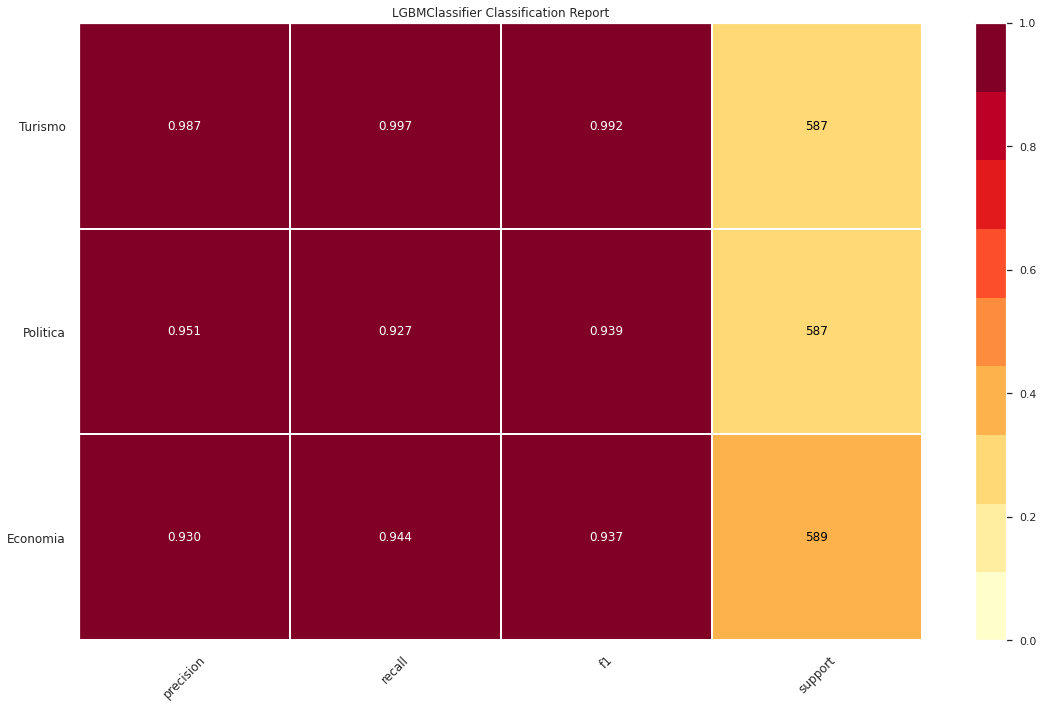

In [ ]:
# Reporte de clasificación
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.score(test_data_vec, test_target)
visualizer.show()

/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


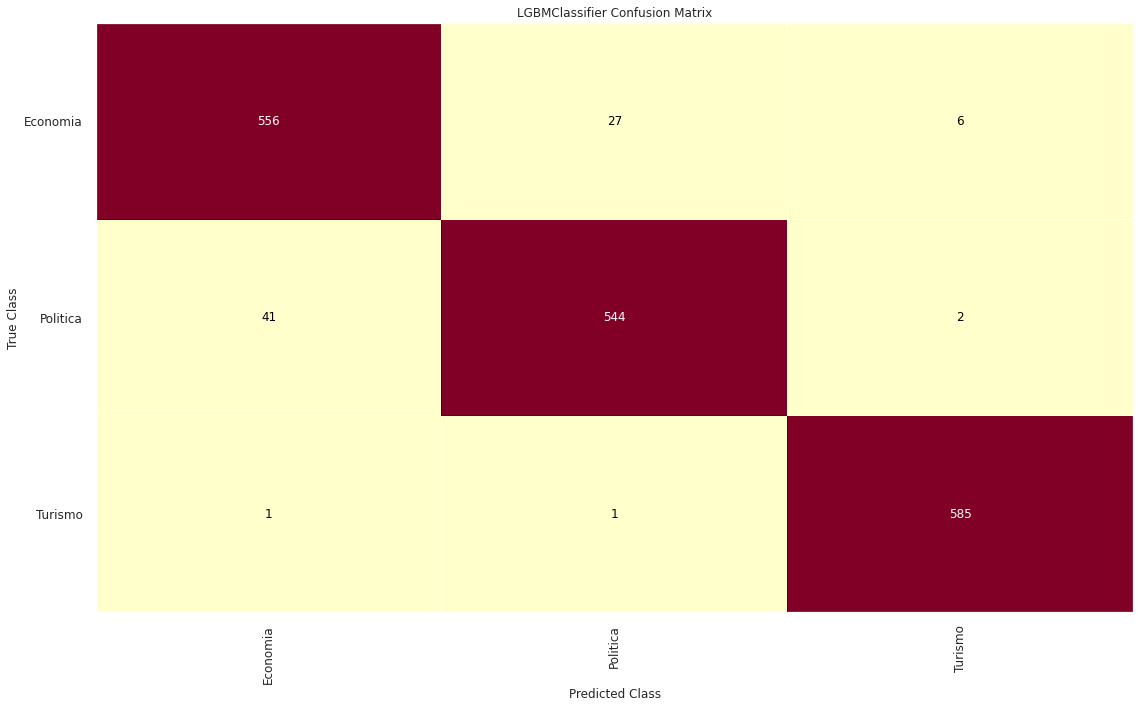

In [ ]:
# Matriz de confusión
visualizer = ConfusionMatrix(
    model,
    classes=classes,
)
visualizer.score(test_data_vec, test_target)
visualizer.show()

Text(0, 0.5, 'Variables')

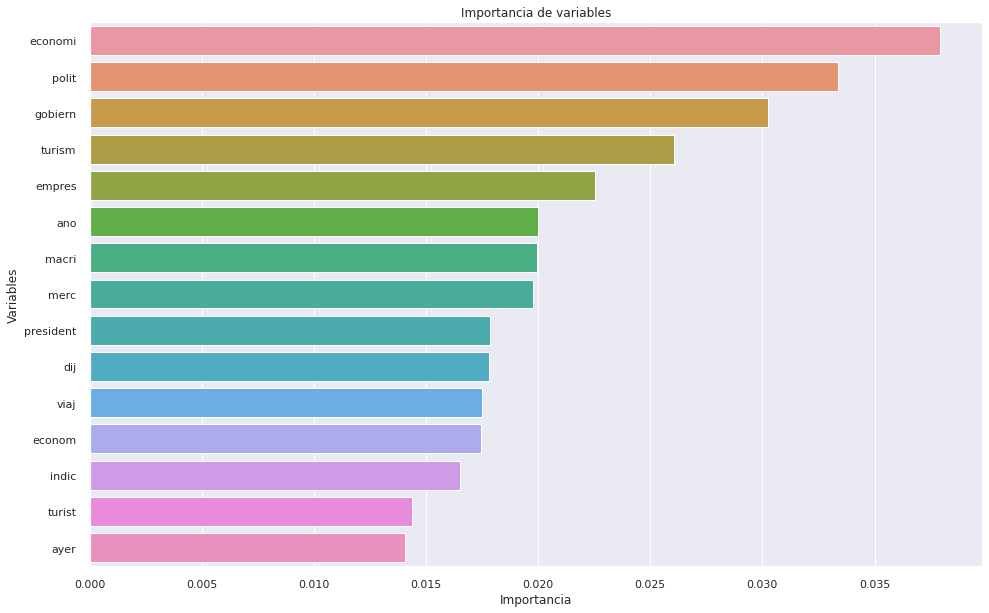

In [ ]:
# Importancia de variables
sns.barplot(x=fi.head(15), y=fi.head(15).index, orient='h')
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')

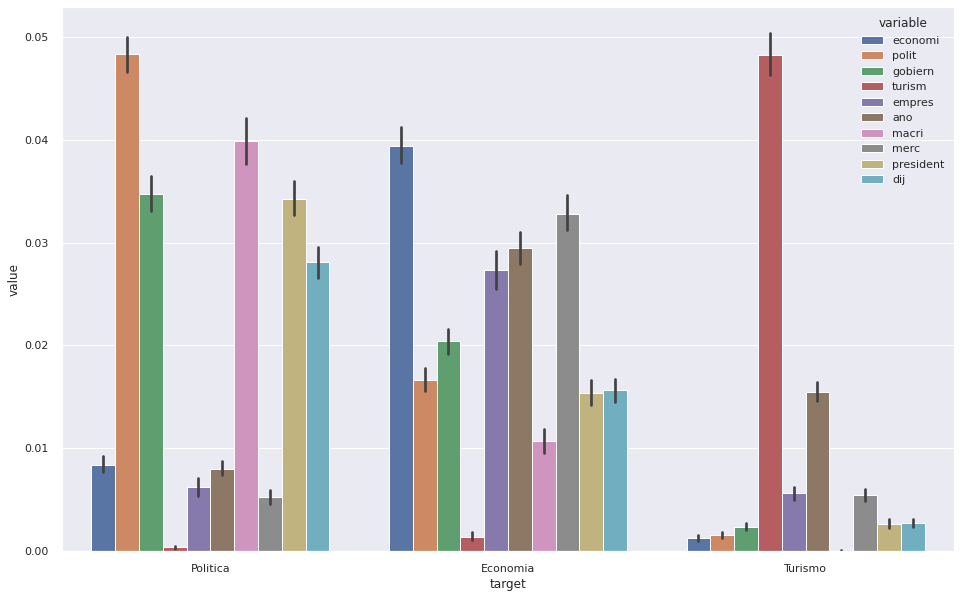

In [ ]:
# Una forma medio extraña de ver la importancia por clase, sirve, aunque no necesariamente es una forma correcta.
train_data_fi = train_data_vec.copy()
train_data_fi['target'] = le.inverse_transform(train_target)
columns = list(fi.head(10).index)
tidy = train_data_fi[columns+['target']].melt(id_vars='target')
sns.barplot(x='target', y='value', hue='variable', data=tidy)

## Conclusiones

Como era de esperarse, el clasificador tiene más facilidad para discriminar la clase "Turismo" de las otras. Tanto la clase "Política" como "Economía" presentan una mayor dificultad por incluir características que pueden ser de ambas. A modo de ejemplo, si bien como surge de la importancia de variables la raíz de la palabra asociada a cada categoría es el principal predictor, en el caso de "Política" y "Economía" estas palabras se encuentran asociadas a ambas categorías, es decir, "Política" aparece en notas de "Economía" y viceversa. Lo mismo sucede con otras palabras o nombres propios.